## 1-bit Deutsch-Jozsa

## Imports and Setup

In [1]:
# Standard Library Imports
import os
import re
import json
import random
import multiprocessing
from typing import Any, Tuple

# Third-party Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile,ClassicalRegister,QuantumRegister
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import QasmSimulator
from qiskit.visualization import plot_histogram
from IPython.display import display
from deap import creator, base, tools

import grape  # Grammatical evolution library
from grape import algorithms  # Evolutionary algorithms

In [2]:
# QiskitRuntimeService.save_account(channel="ibm_quantum", token="7a7db01ab67f2e9082827e16b71b7ca5230d0c4137133a0c9c28a70c96a12bfc92df1005263db0b17d7885549ea8326c9f04f6f3fb409ff08c633ebff8b59561", overwrite=True)

In [3]:
# Get the number of logical CPU cores available
# num_cores = os.cpu_count()
# print("Number of CPU cores available:", num_cores)

In [4]:
BNF_GRAMMAR = grape.Grammar("grammars/xor.bnf")

In [5]:
SEED = 2526
random.seed(SEED)
np.random.seed(SEED)

In [6]:
def apply_oracle_constant0(qc: QuantumCircuit):
    # f(x)=0: never flip the ancilla (qubit 1)
    pass

def apply_oracle_constant1(qc: QuantumCircuit):
    # f(x)=1: always flip the ancilla
    qc.x(1)

def apply_oracle_balanced0to1(qc: QuantumCircuit):
    # f(x)=x: flip ancilla if input==1
    qc.cx(0, 1)

def apply_oracle_balanced1to0(qc: QuantumCircuit):
    # f(x)=¬x: flip ancilla if input==0
    qc.x(0)
    qc.cx(0, 1)
    qc.x(0)

ORACLES = {
    "constant0":   apply_oracle_constant0,
    "constant1":   apply_oracle_constant1,
    "balanced0to1": apply_oracle_balanced0to1,
    "balanced1to0": apply_oracle_balanced1to0,
}

In [7]:
def get_measurement_probabilities(qc: QuantumCircuit, shots: int = 512):
    sim = QasmSimulator()
    tqc = transpile(qc, sim)
    job = sim.run(tqc, shots=shots)
    counts = job.result().get_counts()
    return {out: cnt/shots for out, cnt in counts.items()}

In [8]:
def classify_circuit(probs: dict, threshold: float = 0.5):
    # input qubit is c1 (first bit of the bitstring)
    p0 = sum(p for bitstr, p in probs.items() if bitstr[0] == '0')
    return "constant" if p0 >= threshold else "balanced"

def is_correct_classification(name: str, pred: str):
    truth = "constant" if name.startswith("constant") else "balanced"
    return pred == truth


In [9]:
class DJ1BitEvaluator:
    def __init__(self,
                 shots: int = 512,
                 ):
        self.shots = shots
        self.oracles = ORACLES

    def decode_individual(self, ind) -> str:
        if ind.invalid or not hasattr(ind, "phenotype"):
            return None
        code = ind.phenotype
        if isinstance(code, list):
            code = "".join(code)
        code = re.sub(r"\\n", "\n", code)
        code = re.sub(r'^"|"$', "", code)
        code = re.sub(r'"\s+"', "\n", code)
        return code

    def code_to_circuit(self, code_str: str) -> QuantumCircuit:
        """Only exec if code_str is a non-empty string."""
        if not isinstance(code_str, str) or not code_str.strip():
            return None
        local = {}
        try:
            exec(code_str, globals(), local)
            return local.get("qc")
        except Exception:
            return None

    def build_test_circuit(self, code_str: str, oracle_fn) -> QuantumCircuit:
        qc = self.code_to_circuit(code_str)
        if qc is None:
            return None

        # find the two barrier positions in qc.data
        barrier_idxs = [i for i, (instr, _, _) in enumerate(qc.data)
                        if instr.name == "barrier"]
        if len(barrier_idxs) < 2:
            return None   # we expected exactly two barriers around the oracle slot

        pre, post = barrier_idxs[0], barrier_idxs[1]

        # 1) copy everything up to _and including_ the first barrier
        new_qc = QuantumCircuit(*qc.qregs, *qc.cregs)
        for instr, qargs, cargs in qc.data[: pre + 1]:
            new_qc.append(instr, qargs, cargs)

        # 2) inject the oracle here
        oracle_fn(new_qc)

        # 3) copy everything _after_ the second barrier
        for instr, qargs, cargs in qc.data[post + 1 :]:
            new_qc.append(instr, qargs, cargs)

        return new_qc
    
    def fitness(self, ind: Any) -> Tuple[float]:
        code_str = self.decode_individual(ind)
        if not isinstance(code_str, str):
            return (float("inf"),)

        # 1) build scaffold (no oracle)
        scaffold = self.code_to_circuit(code_str)
        if scaffold is None:
            return (float("inf"),)

        num_misses = 0
        max_error = 0.0

        # 2) test each oracle
        for name, oracle_fn in self.oracles.items():
            qc_full = self.build_test_circuit(code_str, oracle_fn)
            if qc_full is None:
                return (float("inf"),)

            probs = get_measurement_probabilities(qc_full, self.shots)
            p0 = sum(p for bits, p in probs.items() if bits[0] == '0')

            # error_i = Pr[wrong answer]
            if name.startswith("constant"):
                error_i = 1.0 - p0  # want p0 ≈ 1
            else:
                error_i = p0        # want p0 ≈ 0

            # “miss” if error_i > 0.5
            if error_i > 0.5:
                num_misses += 1

            # track the worst‐case error
            max_error = max(max_error, error_i)

        # 3) fitness = misses + worst‐case error
        fitness = num_misses + max_error
        return (fitness,)

In [10]:
POPULATION_SIZE    = 100
MAX_GENERATIONS    = 50
P_CROSSOVER        = 0.7    
P_MUTATION         = 0.1
ELITE_SIZE         = 1
HALLOFFAME_SIZE    = 1
CODON_SIZE         = 100
MAX_TREE_DEPTH     = 50      
TOURNAMENT_SIZE    = 5
MIN_INIT_DEPTH     = 9        
MAX_INIT_DEPTH     = 20       
CODON_CONSUMPTION  = "lazy"   
GENOME_REPRESENTATION='list'
REPORT_ITEMS = ['gen', 'invalid', 'avg', 'std', 'min', 'max','fitness_test',
                'best_ind_length', 'avg_length',
                'best_ind_nodes', 'avg_nodes','avg_depth',
                'avg_used_codons', 'best_ind_used_codons',
                'selection_time', 'generation_time']

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", grape.Individual, fitness=creator.FitnessMin)

# Toolbox
toolbox = base.Toolbox()
toolbox.register("populationCreator",
                 grape.sensible_initialisation,
                 creator.Individual,
                 bnf_grammar=BNF_GRAMMAR,
                 min_init_depth=MIN_INIT_DEPTH,
                 max_init_depth=MAX_INIT_DEPTH,
                 codon_size=CODON_SIZE,
                 codon_consumption=CODON_CONSUMPTION,
                 genome_representation=GENOME_REPRESENTATION)
toolbox.register("mate",    grape.crossover_onepoint)
toolbox.register("mutate",  grape.mutation_int_flip_per_codon)
toolbox.register("select",  tools.selTournament, tournsize=TOURNAMENT_SIZE)


In [11]:
evaluator = DJ1BitEvaluator(shots=512)
def evaluate(individual: Any, points_train=None) -> Tuple[float]:
    # Decode + evaluate in one shot
    return evaluator.fitness(individual)
toolbox.register("evaluate", evaluate)

/var/folders/rc/j294rj094lb9j6zz6fcghj7m0000gn/T/ipykernel_35961/1004322376.py:36: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  barrier_idxs = [i for i, (instr, _, _) in enumerate(qc.data)
/var/folders/rc/j294rj094lb9j6zz6fcghj7m0000gn/T/ipykernel_35961/1004322376.py:45: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in qc.data[: pre + 1]:
/var/folders/rc/j294rj094lb9j6zz6fcghj7m0000gn/T/ipykernel_35961/1004322376.py:52: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named att

gen = 0 , Best fitness = (0.0,)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (0.0,) , Number of invalids = 13
[Gen 0] Best fitness: 0.0000


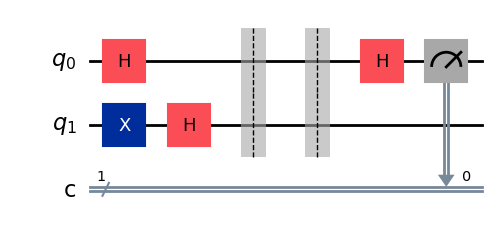

gen = 0 , Best fitness = (0.0,)
gen = 1 , Best fitness = (0.0,) , Number of invalids = 9
[Gen 1] Best fitness: 0.0000


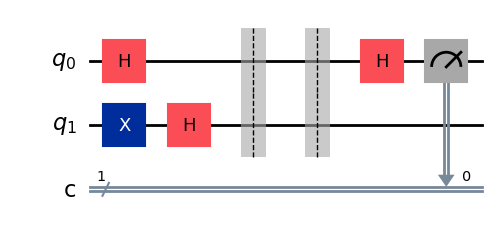

gen = 0 , Best fitness = (0.0,)
gen = 1 , Best fitness = (0.0,) , Number of invalids = 10
[Gen 2] Best fitness: 0.0000


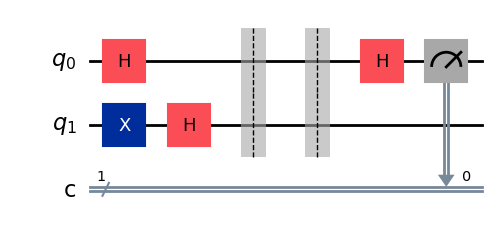

gen = 0 , Best fitness = (0.0,)
gen = 1 , Best fitness = (0.0,) , Number of invalids = 18
[Gen 3] Best fitness: 0.0000


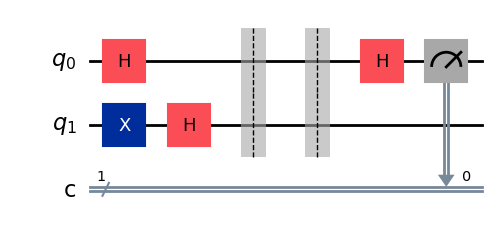

gen = 0 , Best fitness = (0.0,)
gen = 1 , Best fitness = (0.0,) , Number of invalids = 12
[Gen 4] Best fitness: 0.0000


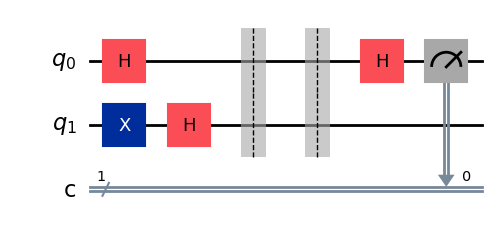

gen = 0 , Best fitness = (0.0,)
gen = 1 , Best fitness = (0.0,) , Number of invalids = 14
[Gen 5] Best fitness: 0.0000


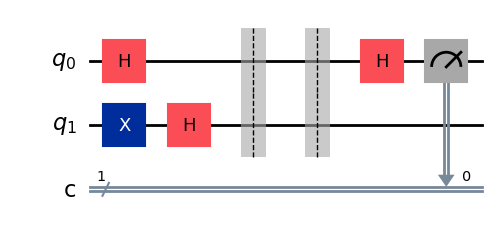

gen = 0 , Best fitness = (0.0,)
gen = 1 , Best fitness = (0.0,) , Number of invalids = 13
[Gen 6] Best fitness: 0.0000


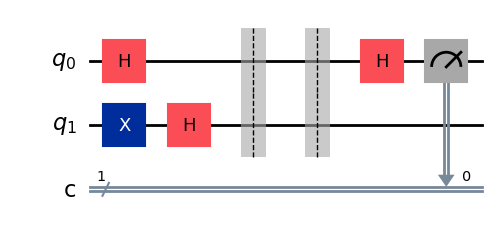

gen = 0 , Best fitness = (0.0,)
gen = 1 , Best fitness = (0.0,) , Number of invalids = 14
[Gen 7] Best fitness: 0.0000


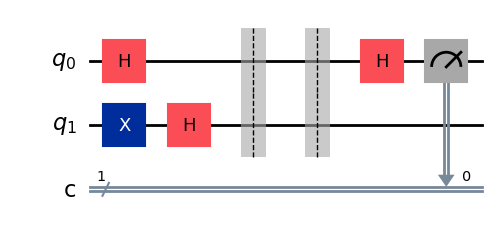

gen = 0 , Best fitness = (0.0,)
gen = 1 , Best fitness = (0.0,) , Number of invalids = 13
[Gen 8] Best fitness: 0.0000


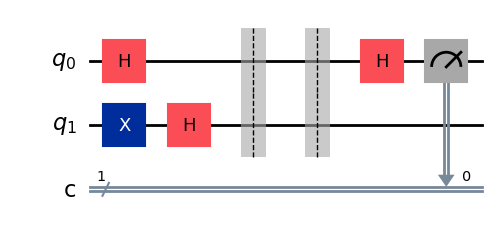

gen = 0 , Best fitness = (0.0,)
gen = 1 , Best fitness = (0.0,) , Number of invalids = 9
[Gen 9] Best fitness: 0.0000


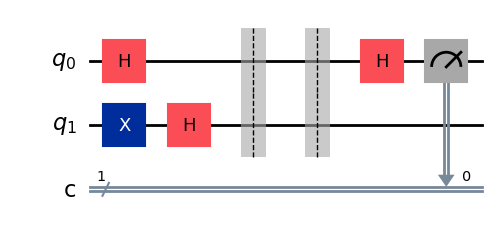

gen = 0 , Best fitness = (0.0,)
gen = 1 , Best fitness = (0.0,) , Number of invalids = 8
[Gen 10] Best fitness: 0.0000


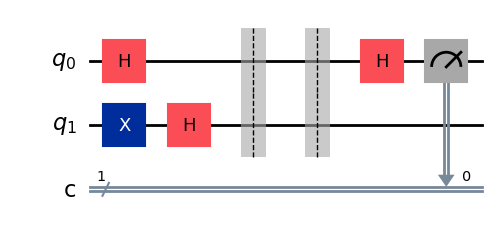

gen = 0 , Best fitness = (0.0,)
gen = 1 , Best fitness = (0.0,) , Number of invalids = 16
[Gen 11] Best fitness: 0.0000


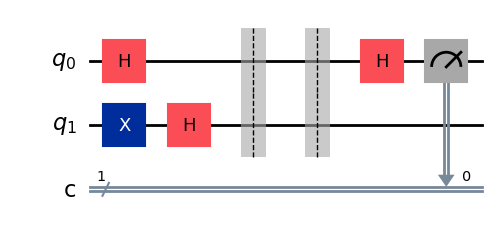

gen = 0 , Best fitness = (0.0,)
gen = 1 , Best fitness = (0.0,) , Number of invalids = 9
[Gen 12] Best fitness: 0.0000


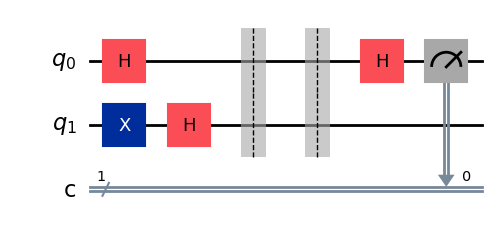

gen = 0 , Best fitness = (0.0,)
gen = 1 , Best fitness = (0.0,) , Number of invalids = 3
[Gen 13] Best fitness: 0.0000


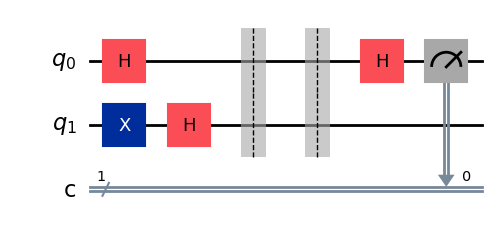

gen = 0 , Best fitness = (0.0,)
gen = 1 , Best fitness = (0.0,) , Number of invalids = 9
[Gen 14] Best fitness: 0.0000


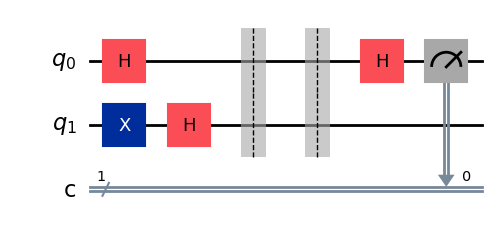

gen = 0 , Best fitness = (0.0,)
gen = 1 , Best fitness = (0.0,) , Number of invalids = 3
[Gen 15] Best fitness: 0.0000


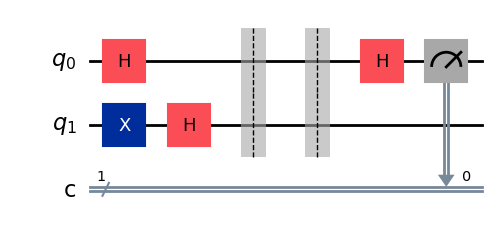

gen = 0 , Best fitness = (0.0,)
gen = 1 , Best fitness = (0.0,) , Number of invalids = 5
[Gen 16] Best fitness: 0.0000


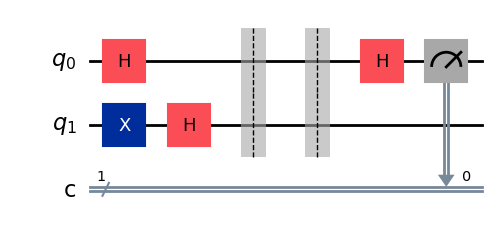

gen = 0 , Best fitness = (0.0,)
gen = 1 , Best fitness = (0.0,) , Number of invalids = 5
[Gen 17] Best fitness: 0.0000


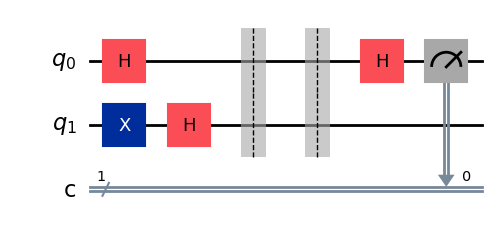

gen = 0 , Best fitness = (0.0,)
gen = 1 , Best fitness = (0.0,) , Number of invalids = 4
[Gen 18] Best fitness: 0.0000


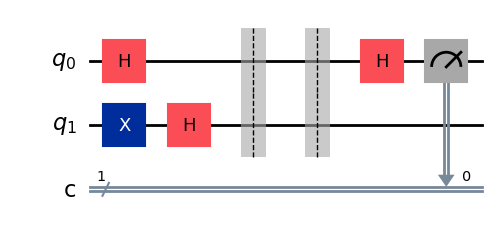

gen = 0 , Best fitness = (0.0,)
gen = 1 , Best fitness = (0.0,) , Number of invalids = 4
[Gen 19] Best fitness: 0.0000


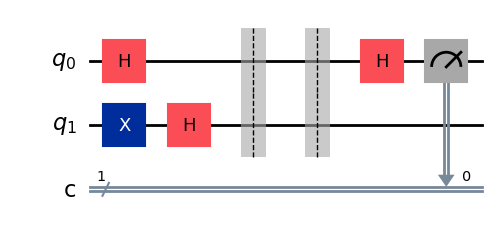

gen = 0 , Best fitness = (0.0,)
gen = 1 , Best fitness = (0.0,) , Number of invalids = 0
[Gen 20] Best fitness: 0.0000


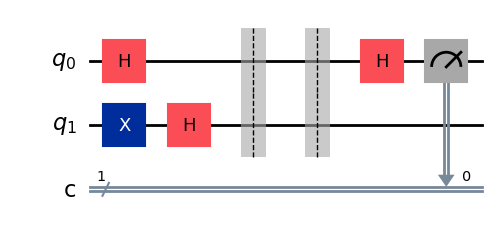

gen = 0 , Best fitness = (0.0,)
gen = 1 , Best fitness = (0.0,) , Number of invalids = 4
[Gen 21] Best fitness: 0.0000


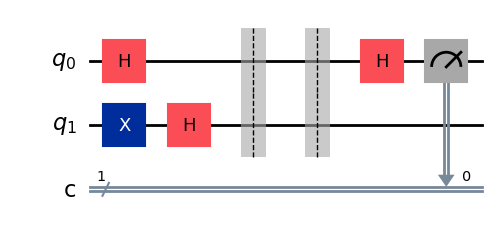

gen = 0 , Best fitness = (0.0,)
gen = 1 , Best fitness = (0.0,) , Number of invalids = 5
[Gen 22] Best fitness: 0.0000


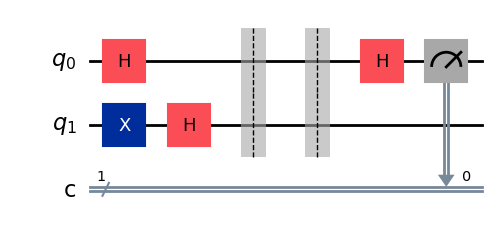

gen = 0 , Best fitness = (0.0,)
gen = 1 , Best fitness = (0.0,) , Number of invalids = 5
[Gen 23] Best fitness: 0.0000


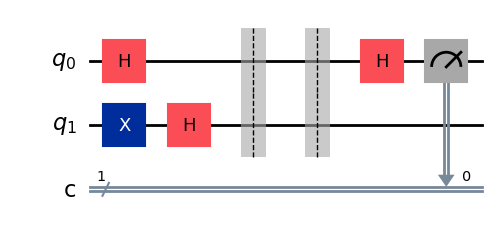

gen = 0 , Best fitness = (0.0,)
gen = 1 , Best fitness = (0.0,) , Number of invalids = 6
[Gen 24] Best fitness: 0.0000


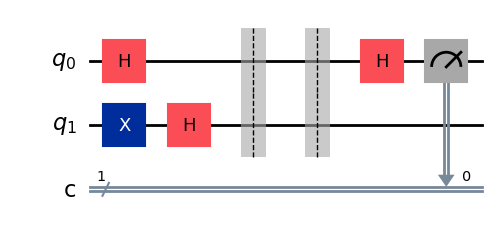

gen = 0 , Best fitness = (0.0,)
gen = 1 , Best fitness = (0.0,) , Number of invalids = 7
[Gen 25] Best fitness: 0.0000


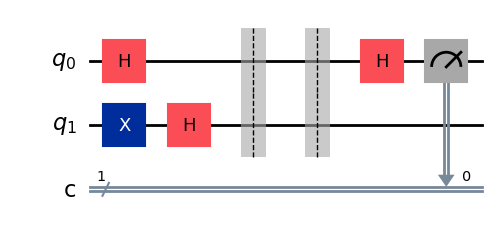

gen = 0 , Best fitness = (0.0,)
gen = 1 , Best fitness = (0.0,) , Number of invalids = 3
[Gen 26] Best fitness: 0.0000


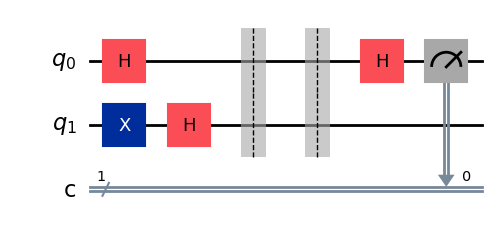

gen = 0 , Best fitness = (0.0,)
gen = 1 , Best fitness = (0.0,) , Number of invalids = 3
[Gen 27] Best fitness: 0.0000


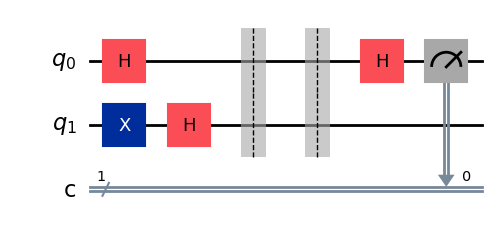

gen = 0 , Best fitness = (0.0,)
gen = 1 , Best fitness = (0.0,) , Number of invalids = 3
[Gen 28] Best fitness: 0.0000


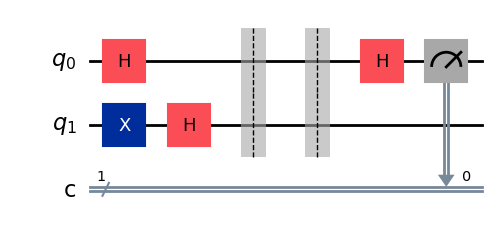

gen = 0 , Best fitness = (0.0,)
gen = 1 , Best fitness = (0.0,) , Number of invalids = 1
[Gen 29] Best fitness: 0.0000


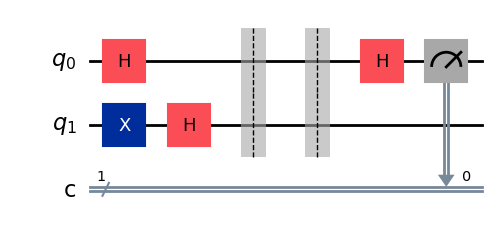

gen = 0 , Best fitness = (0.0,)
gen = 1 , Best fitness = (0.0,) , Number of invalids = 2
[Gen 30] Best fitness: 0.0000


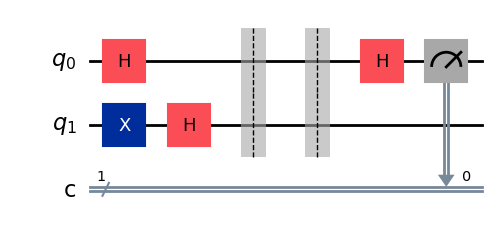

gen = 0 , Best fitness = (0.0,)
gen = 1 , Best fitness = (0.0,) , Number of invalids = 4
[Gen 31] Best fitness: 0.0000


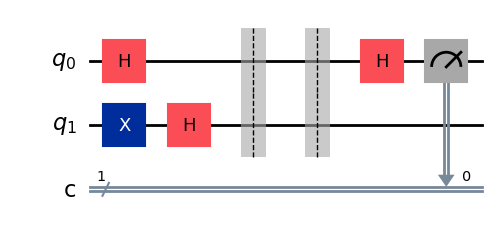

gen = 0 , Best fitness = (0.0,)
gen = 1 , Best fitness = (0.0,) , Number of invalids = 6
[Gen 32] Best fitness: 0.0000


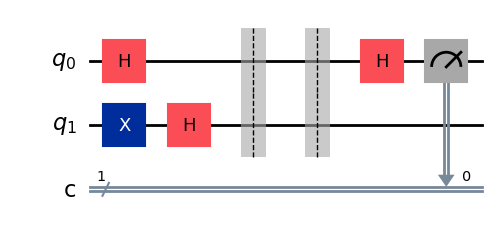

gen = 0 , Best fitness = (0.0,)
gen = 1 , Best fitness = (0.0,) , Number of invalids = 4
[Gen 33] Best fitness: 0.0000


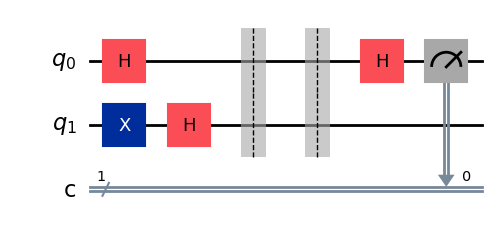

gen = 0 , Best fitness = (0.0,)
gen = 1 , Best fitness = (0.0,) , Number of invalids = 5
[Gen 34] Best fitness: 0.0000


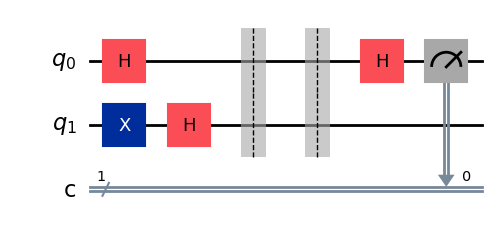

gen = 0 , Best fitness = (0.0,)
gen = 1 , Best fitness = (0.0,) , Number of invalids = 4
[Gen 35] Best fitness: 0.0000


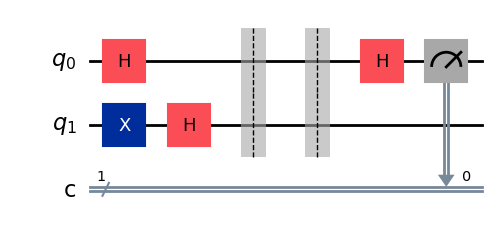

gen = 0 , Best fitness = (0.0,)
gen = 1 , Best fitness = (0.0,) , Number of invalids = 8
[Gen 36] Best fitness: 0.0000


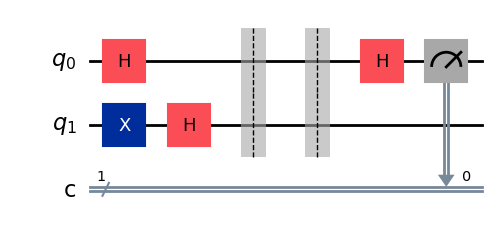

gen = 0 , Best fitness = (0.0,)
gen = 1 , Best fitness = (0.0,) , Number of invalids = 3
[Gen 37] Best fitness: 0.0000


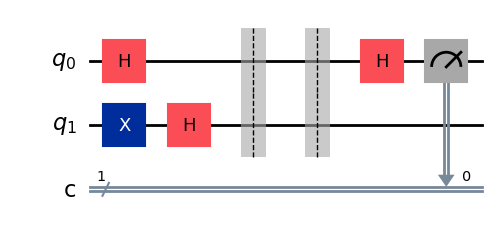

gen = 0 , Best fitness = (0.0,)
gen = 1 , Best fitness = (0.0,) , Number of invalids = 6
[Gen 38] Best fitness: 0.0000


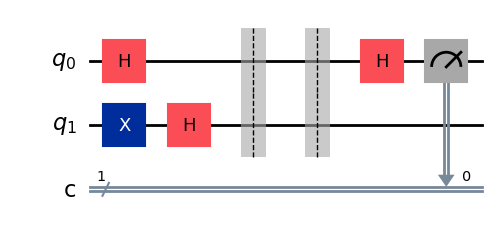

gen = 0 , Best fitness = (0.0,)
gen = 1 , Best fitness = (0.0,) , Number of invalids = 6
[Gen 39] Best fitness: 0.0000


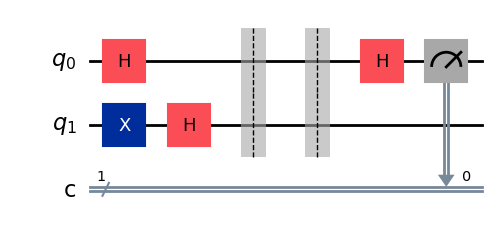

gen = 0 , Best fitness = (0.0,)
gen = 1 , Best fitness = (0.0,) , Number of invalids = 6
[Gen 40] Best fitness: 0.0000


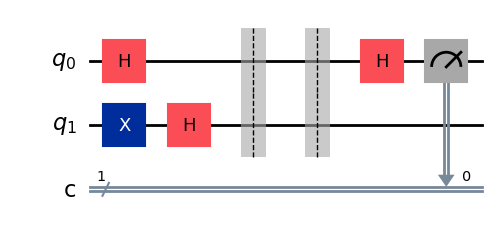

gen = 0 , Best fitness = (0.0,)
gen = 1 , Best fitness = (0.0,) , Number of invalids = 2
[Gen 41] Best fitness: 0.0000


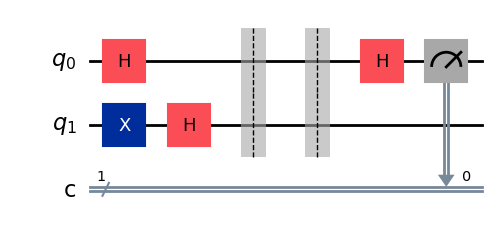

gen = 0 , Best fitness = (0.0,)
gen = 1 , Best fitness = (0.0,) , Number of invalids = 3
[Gen 42] Best fitness: 0.0000


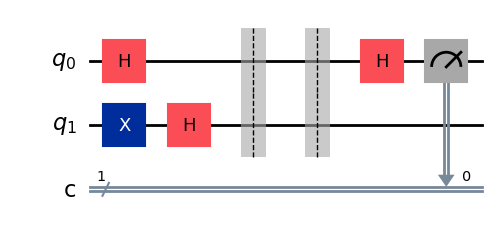

gen = 0 , Best fitness = (0.0,)
gen = 1 , Best fitness = (0.0,) , Number of invalids = 0
[Gen 43] Best fitness: 0.0000


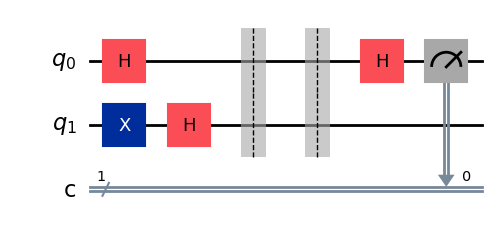

gen = 0 , Best fitness = (0.0,)
gen = 1 , Best fitness = (0.0,) , Number of invalids = 1
[Gen 44] Best fitness: 0.0000


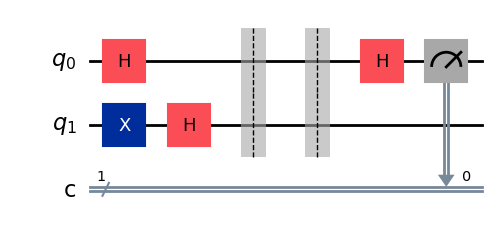

gen = 0 , Best fitness = (0.0,)
gen = 1 , Best fitness = (0.0,) , Number of invalids = 1
[Gen 45] Best fitness: 0.0000


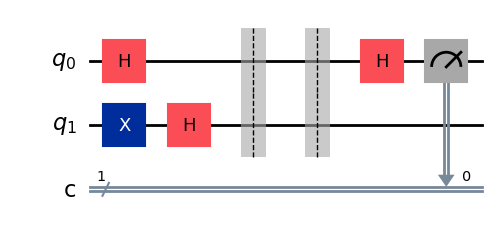

gen = 0 , Best fitness = (0.0,)
gen = 1 , Best fitness = (0.0,) , Number of invalids = 2
[Gen 46] Best fitness: 0.0000


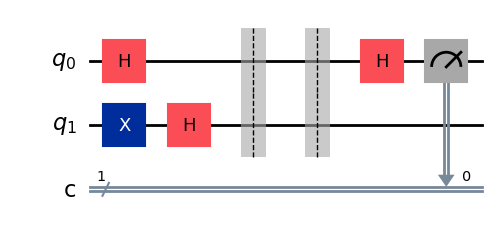

gen = 0 , Best fitness = (0.0,)
gen = 1 , Best fitness = (0.0,) , Number of invalids = 7
[Gen 47] Best fitness: 0.0000


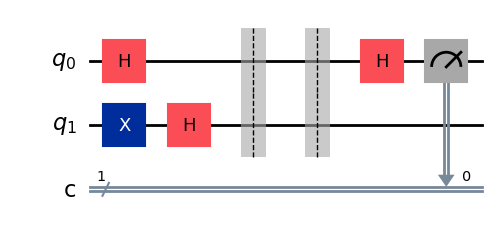

gen = 0 , Best fitness = (0.0,)
gen = 1 , Best fitness = (0.0,) , Number of invalids = 3
[Gen 48] Best fitness: 0.0000


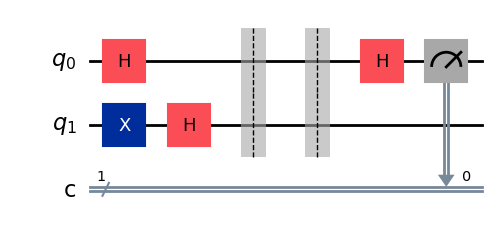

gen = 0 , Best fitness = (0.0,)
gen = 1 , Best fitness = (0.0,) , Number of invalids = 1
[Gen 49] Best fitness: 0.0000


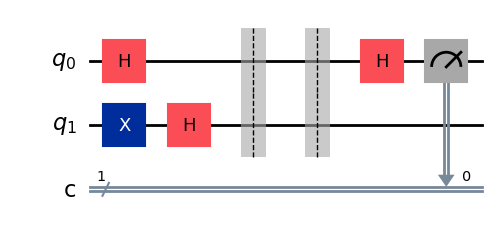

In [12]:
# Initialize population, hall‐of‐fame, and stats
population = toolbox.populationCreator(pop_size=POPULATION_SIZE)
hof        = tools.HallOfFame(HALLOFFAME_SIZE)


# Prepare statistics
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

generations       = []
best_fitness      = []
invalid_counts    = []

# Evolution loop, one generation at a time
for gen in range(MAX_GENERATIONS):
    population, logbook = algorithms.ge_eaSimpleWithElitism(
        population,
        toolbox,
        cxpb=P_CROSSOVER,
        mutpb=P_MUTATION,
        ngen=1,
        elite_size=ELITE_SIZE,
        bnf_grammar=BNF_GRAMMAR,
        codon_size=CODON_SIZE,
        max_tree_depth=MAX_TREE_DEPTH,
        codon_consumption=CODON_CONSUMPTION,
        genome_representation=GENOME_REPRESENTATION,
        stats=stats,
        halloffame=hof,
        report_items=REPORT_ITEMS,
        verbose=False
    )

    # record this generation
    generations.append(gen)

    # best fitness for this generation
    record = logbook[0]
    best_fitness.append(record['min'])

    # count invalid individuals
    n_invalid = sum(1 for ind in population if getattr(ind, "invalid", False))
    invalid_counts.append(n_invalid)

    # display best scaffold
    best = tools.selBest(population, 1)[0]
    print(f"[Gen {gen}] Best fitness: {best.fitness.values[0]:.4f}")
    qc0 = evaluator.code_to_circuit(evaluator.decode_individual(best))
    if qc0:
        display(qc0.draw("mpl"))

    # now show each oracle plugged in
    # for name, oracle_fn in ORACLES.items():
    #     qc_full = evaluator.build_test_circuit(best_code, oracle_fn)
    #     print(f"    ↳ Oracle = {name}")
    #     if qc_full:
    #         display(qc_full.draw("mpl"))
    #         counts = get_measurement_probabilities(qc_full, shots=evaluator.shots)
    #         # print(f"      Counts: {counts}")
    #         # display(plot_histogram(counts, title=name))


[HALL OF FAME]
Fitness: (0.0,)

Oracle: constant0


/var/folders/rc/j294rj094lb9j6zz6fcghj7m0000gn/T/ipykernel_35961/1004322376.py:36: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  barrier_idxs = [i for i, (instr, _, _) in enumerate(qc.data)
/var/folders/rc/j294rj094lb9j6zz6fcghj7m0000gn/T/ipykernel_35961/1004322376.py:45: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in qc.data[: pre + 1]:
/var/folders/rc/j294rj094lb9j6zz6fcghj7m0000gn/T/ipykernel_35961/1004322376.py:52: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named att

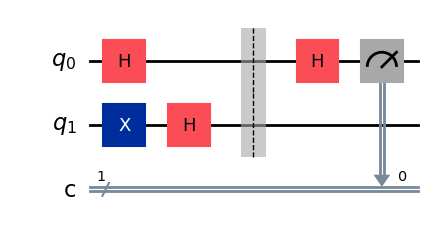

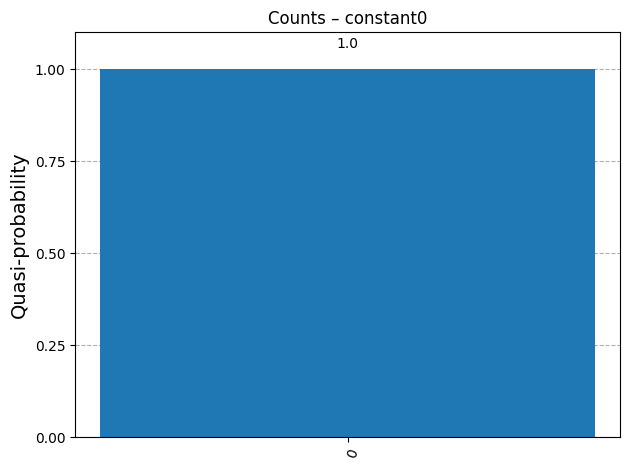

Raw counts: {'0': 1.0}

Oracle: constant1


/var/folders/rc/j294rj094lb9j6zz6fcghj7m0000gn/T/ipykernel_35961/1004322376.py:36: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  barrier_idxs = [i for i, (instr, _, _) in enumerate(qc.data)
/var/folders/rc/j294rj094lb9j6zz6fcghj7m0000gn/T/ipykernel_35961/1004322376.py:45: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in qc.data[: pre + 1]:
/var/folders/rc/j294rj094lb9j6zz6fcghj7m0000gn/T/ipykernel_35961/1004322376.py:52: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named att

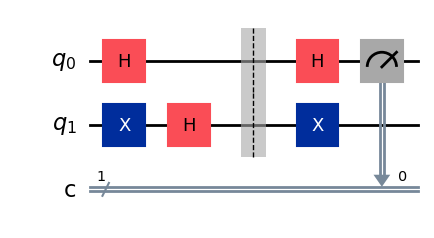

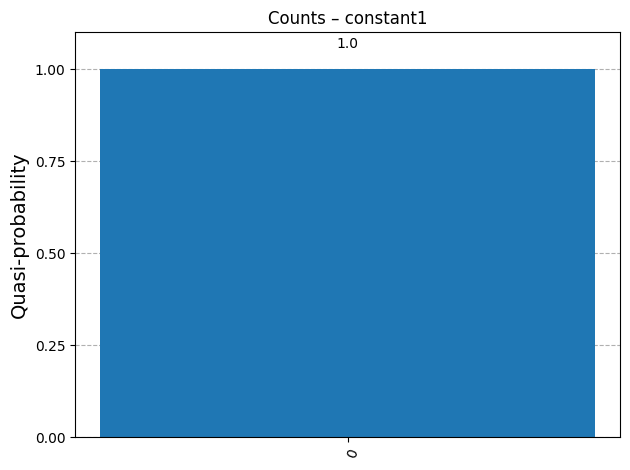

Raw counts: {'0': 1.0}

Oracle: balanced0to1


/var/folders/rc/j294rj094lb9j6zz6fcghj7m0000gn/T/ipykernel_35961/1004322376.py:36: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  barrier_idxs = [i for i, (instr, _, _) in enumerate(qc.data)
/var/folders/rc/j294rj094lb9j6zz6fcghj7m0000gn/T/ipykernel_35961/1004322376.py:45: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in qc.data[: pre + 1]:
/var/folders/rc/j294rj094lb9j6zz6fcghj7m0000gn/T/ipykernel_35961/1004322376.py:52: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named att

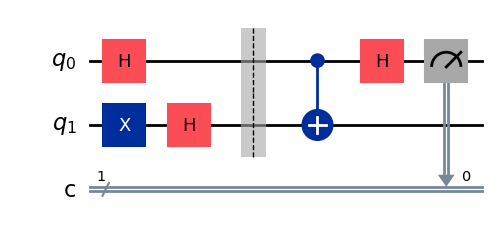

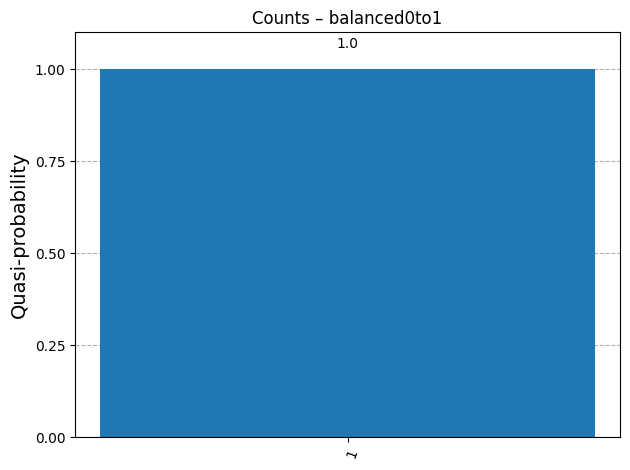

Raw counts: {'1': 1.0}

Oracle: balanced1to0


/var/folders/rc/j294rj094lb9j6zz6fcghj7m0000gn/T/ipykernel_35961/1004322376.py:36: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  barrier_idxs = [i for i, (instr, _, _) in enumerate(qc.data)
/var/folders/rc/j294rj094lb9j6zz6fcghj7m0000gn/T/ipykernel_35961/1004322376.py:45: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in qc.data[: pre + 1]:
/var/folders/rc/j294rj094lb9j6zz6fcghj7m0000gn/T/ipykernel_35961/1004322376.py:52: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named att

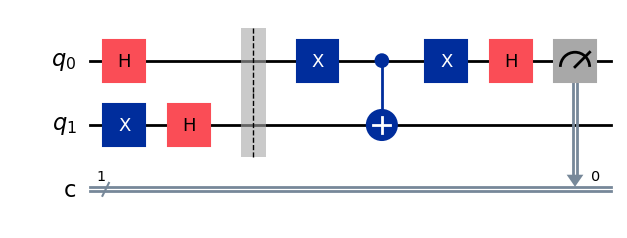

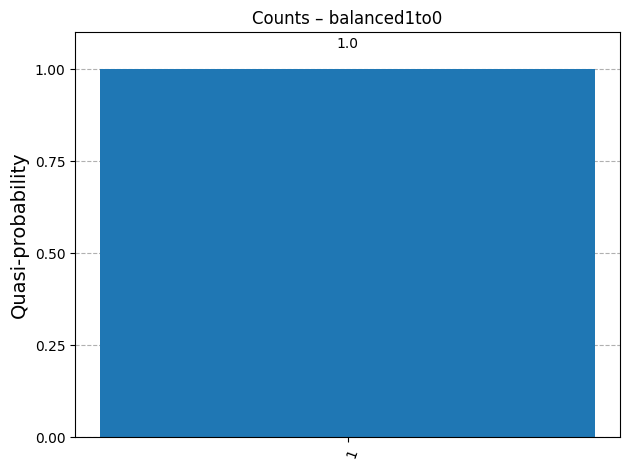

Raw counts: {'1': 1.0}


In [13]:
print("\n[HALL OF FAME]")
# Get the best individual from the hall of fame
best_ind = hof.items[0]
code_str = evaluator.decode_individual(best_ind)
print("Fitness:", best_ind.fitness.values)

# Now, build and display the full circuits with each oracle plugged into the best scaffold
for name, oracle_fn in ORACLES.items():
    # build_test_circuit inserts the oracle at the placeholder
    qc_full = evaluator.build_test_circuit(code_str, oracle_fn)

    if qc_full:
        counts = get_measurement_probabilities(qc_full, shots=evaluator.shots)
        print(f"\nOracle: {name}")
        display(qc_full.draw("mpl")) # Display the circuit with the oracle
        display(plot_histogram(counts, title=f"Counts – {name}"))
        print("Raw counts:", counts)
    else:
        print(f"\nCould not build valid circuit for Oracle: {name}")
        print(f"Scaffold code:\n{code_str}")


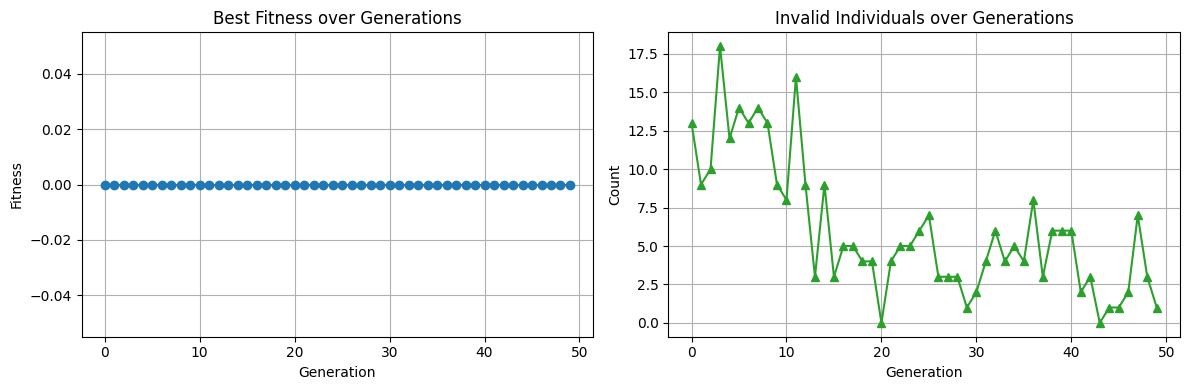

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

ax1.plot(generations, best_fitness, '-o', label="Best Fitness")
ax1.set_title("Best Fitness over Generations")
ax1.set_xlabel("Generation")
ax1.set_ylabel("Fitness")
ax1.grid(True)

ax2.plot(generations, invalid_counts, '-^', color='C2', label="Invalid Individuals")
ax2.set_title("Invalid Individuals over Generations")
ax2.set_xlabel("Generation")
ax2.set_ylabel("Count")
ax2.grid(True)

plt.tight_layout()
plt.show()